Sources: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Data Importing

In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
VDH_covid19_raw = pd.read_csv("https://raw.githubusercontent.com/dszabo236/cs4774Assigments/main/VDH-COVID-19-PublicUseDataset-Cases.csv")

Med_HouseIncome_raw = pd.read_csv("https://raw.githubusercontent.com/carterbristow/NodeLiteF20/master/Median_Household_Income_by_race_ethnicity_by_Virginia_locality.csv")
demographics_raw = pd.read_csv("https://raw.githubusercontent.com/carterbristow/NodeLiteF20/master/ACSDP5Y2019.DP05_data_with_overlays_2021-04-06T104558.csv")
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='\dM')))] # Margins
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='P[EM]')))] # Other Margins 
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='8[7-9]')))] # Remove voting info
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='001[9]')))] # Remove under 18 
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='00[2]\d')))] #Age groups age and up
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='000[4]')))] #male/female ratio
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='003[0124]')))] # Remove age over 65/unnecesary pop data
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='003[69]')))] # Editing pop
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='004[012356789]')))] # REmoving subdemographic asian population
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='005[01234569]')))] # removed native american subdemographic groups
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='006\d')))] # All combination race
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='007[023456789]')))] # Removing hispanic or latino subgroups
demographics_raw = demographics_raw[demographics_raw.columns.drop(list(demographics_raw.filter(regex='008[0123456]')))] # Two or more race and housing units
#Above I removed a bunch of unnessicary data such as percentages margins and other data not relevent to our project

pd.set_option('display.max_colwidth', -1) 
demographics_raw

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,GEO_ID,NAME,DP05_0001E,DP05_0002E,DP05_0003E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,DP05_0009E,DP05_0010E,DP05_0011E,DP05_0012E,DP05_0013E,DP05_0014E,DP05_0015E,DP05_0016E,DP05_0017E,DP05_0018E,DP05_0033E,DP05_0035E,DP05_0037E,DP05_0038E,DP05_0044E,DP05_0057E,DP05_0058E,DP05_0071E
0,id,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Estimate!!SEX AND AGE!!Total population!!Female,Estimate!!SEX AND AGE!!Total population!!Under 5 years,Estimate!!SEX AND AGE!!Total population!!5 to 9 years,Estimate!!SEX AND AGE!!Total population!!10 to 14 years,Estimate!!SEX AND AGE!!Total population!!15 to 19 years,Estimate!!SEX AND AGE!!Total population!!20 to 24 years,Estimate!!SEX AND AGE!!Total population!!25 to 34 years,Estimate!!SEX AND AGE!!Total population!!35 to 44 years,Estimate!!SEX AND AGE!!Total population!!45 to 54 years,Estimate!!SEX AND AGE!!Total population!!55 to 59 years,Estimate!!SEX AND AGE!!Total population!!60 to 64 years,Estimate!!SEX AND AGE!!Total population!!65 to 74 years,Estimate!!SEX AND AGE!!Total population!!75 to 84 years,Estimate!!SEX AND AGE!!Total population!!85 years and over,Estimate!!SEX AND AGE!!Total population!!Median age (years),Estimate!!RACE!!Total population,Estimate!!RACE!!Total population!!Two or more races,Estimate!!RACE!!Total population!!One race!!White,Estimate!!RACE!!Total population!!One race!!Black or African American,Estimate!!RACE!!Total population!!One race!!Asian,Estimate!!RACE!!Total population!!One race!!Some other race,Estimate!!RACE!!Total population!!Two or more races,Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)
1,0500000US51001,"Accomack County, Virginia",32673,15934,16739,1882,1943,1923,1684,1734,3469,3396,3884,2754,2580,4372,2086,966,45.9,32673,341,22282,9331,265,279,341,2929
2,0500000US51003,"Albemarle County, Virginia",107405,51363,56042,5783,6212,5910,9552,7011,13847,12415,12986,7286,7063,10954,5654,2732,39.1,107405,2605,87831,10245,5590,822,2605,6200
3,0500000US51005,"Alleghany County, Virginia",15157,7367,7790,673,856,742,893,765,1576,1525,2079,1173,1268,2030,1064,513,48.1,15157,172,14012,881,16,76,172,225
4,0500000US51007,"Amelia County, Virginia",12953,6580,6373,763,962,556,876,513,1450,1353,1882,1417,698,1490,673,320,45.1,12953,360,9824,2745,0,0,360,390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0500000US51810,"Virginia Beach city, Virginia",450201,221324,228877,28576,27474,27795,26688,32609,74440,58680,57267,29025,25843,36542,18046,7216,36.2,450201,25113,298347,85609,30130,9285,25113,36785
131,0500000US51820,"Waynesboro city, Virginia",22140,10836,11304,1410,1659,1423,1182,1134,3234,2813,2608,1404,1369,2087,1257,560,39.2,22140,472,18025,3149,239,73,472,1788
132,0500000US51830,"Williamsburg city, Virginia",14927,6929,7998,515,475,281,2874,3343,1799,834,1071,642,751,1288,838,216,24.9,14927,535,10961,2246,963,169,535,1053
133,0500000US51840,"Winchester city, Virginia",27897,13694,14203,1872,1882,1606,2226,1775,3704,3239,3958,1594,1598,2534,1339,570,38.1,27897,1183,22878,2808,624,330,1183,4958


In [ ]:
VDH_covid19_raw

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths
0,11/28/2020,51001,Accomack,Eastern Shore,1340,107,21
1,11/28/2020,51003,Albemarle,Thomas Jefferson,1896,100,27
2,11/28/2020,51005,Alleghany,Alleghany,316,19,7
3,11/28/2020,51007,Amelia,Piedmont,210,21,6
4,11/28/2020,51009,Amherst,Central Virginia,810,31,6
...,...,...,...,...,...,...,...
54525,04/30/2021,51800,Suffolk,Western Tidewater,7821,435,185
54526,04/30/2021,51810,Virginia Beach,Virginia Beach,35360,1572,385
54527,04/30/2021,51820,Waynesboro,Central Shenandoah,2345,73,37
54528,04/30/2021,51830,Williamsburg,Peninsula,756,27,12


In [ ]:
VDH_covid19_raw.columns = VDH_covid19_raw.columns.str.replace(' ', '_')
VDH_covid19 = VDH_covid19_raw.where(VDH_covid19_raw.Report_Date == '04/30/2021').dropna()
VDH_covid19 = VDH_covid19.sort_values(by='FIPS')
VDH_covid19.reset_index(drop=True, inplace=True)

VDH_covid19

,Report_Date,FIPS,Locality,VDH_Health_District,Total_Cases,Hospitalizations,Deaths
0,04/30/2021,51001.0,Accomack,Eastern Shore,2810.0,205.0,41.0
1,04/30/2021,51003.0,Albemarle,Blue Ridge,5704.0,217.0,83.0
2,04/30/2021,51005.0,Alleghany,Alleghany,1336.0,58.0,48.0
3,04/30/2021,51007.0,Amelia,Piedmont,878.0,50.0,31.0
4,04/30/2021,51009.0,Amherst,Central Virginia,2902.0,120.0,35.0
...,...,...,...,...,...,...,...
128,04/30/2021,51800.0,Suffolk,Western Tidewater,7821.0,435.0,185.0
129,04/30/2021,51810.0,Virginia Beach,Virginia Beach,35360.0,1572.0,385.0
130,04/30/2021,51820.0,Waynesboro,Central Shenandoah,2345.0,73.0,37.0
131,04/30/2021,51830.0,Williamsburg,Peninsula,756.0,27.0,12.0


In [ ]:
Med_HouseIncome_raw.columns = ['year', 'county', 'Overall_Income', 'White_Income', 'Black_Income', 'African_Income', 'Asian_Income', 'Hawaiian_Income', 'Other_Income', 'Two_Income', 'WhiteNH_Income', 'Hispanic_Income', 'state_code', 'locality_code']
Med_HouseIncome_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   year             1068 non-null   object
 1   county           1068 non-null   object
 2   Overall_Income   1068 non-null   int64 
 3   White_Income     1068 non-null   int64 
 4   Black_Income     1068 non-null   int64 
 5   African_Income   1068 non-null   int64 
 6   Asian_Income     1068 non-null   int64 
 7   Hawaiian_Income  1068 non-null   int64 
 8   Other_Income     1068 non-null   int64 
 9   Two_Income       1068 non-null   int64 
 10  WhiteNH_Income   1068 non-null   int64 
 11  Hispanic_Income  1068 non-null   int64 
 12  state_code       1068 non-null   int64 
 13  locality_code    1068 non-null   int64 
dtypes: int64(12), object(2)
memory usage: 116.9+ KB


# Data Cleaning

In [ ]:
Med_HouseIncome_raw = Med_HouseIncome_raw.replace([-666666666], [None])
Med_HouseIncome = Med_HouseIncome_raw[Med_HouseIncome_raw.columns.drop(['African_Income', 'Hawaiian_Income', 'Other_Income'])]
Med_HouseIncome_avg = pd.DataFrame(columns=Med_HouseIncome.columns[1:])
counties = pd.unique(Med_HouseIncome[['county']].values.ravel())

In [ ]:
Med_HouseIncome_raw = Med_HouseIncome_raw.replace([-666666666], [None])
Med_HouseIncome = Med_HouseIncome_raw[Med_HouseIncome_raw.columns.drop(['African_Income', 'Hawaiian_Income', 'Other_Income'])]
Med_HouseIncome_avg = pd.DataFrame(columns=Med_HouseIncome.columns[1:])
counties = pd.unique(Med_HouseIncome[['county']].values.ravel())
Med_HouseIncome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             1068 non-null   object 
 1   county           1068 non-null   object 
 2   Overall_Income   1068 non-null   int64  
 3   White_Income     1068 non-null   int64  
 4   Black_Income     1017 non-null   float64
 5   Asian_Income     629 non-null    float64
 6   Two_Income       810 non-null    float64
 7   WhiteNH_Income   1068 non-null   int64  
 8   Hispanic_Income  862 non-null    float64
 9   state_code       1068 non-null   int64  
 10  locality_code    1068 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 91.9+ KB


In [ ]:
row = 0
for n in counties: #averages the incomes of the counites based on columns since no specific date had all of the counties
  county_avg = Med_HouseIncome.where(Med_HouseIncome.county == n).dropna(how='all').mean(axis=0)
  new_row = [n, county_avg[0], county_avg[1], county_avg[2], county_avg[3], county_avg[4], county_avg[5], county_avg[6], county_avg[7], county_avg[8]]
  Med_HouseIncome_avg.loc[row] = new_row
  row += 1
Med_HouseIncome_avg = Med_HouseIncome_avg.where(Med_HouseIncome_avg.locality_code != 515).dropna(how='all') #Removed Bedford City because in 2013 it became a town (I live there lol)
Med_HouseIncome_avg = Med_HouseIncome_avg.sort_values(by='locality_code')
Med_HouseIncome_avg = Med_HouseIncome_avg[Med_HouseIncome_avg.columns.drop('state_code')]
Med_HouseIncome_avg.reset_index(drop=True, inplace=True)

Med_HouseIncome_avg

,county,Overall_Income,White_Income,Black_Income,Asian_Income,Two_Income,WhiteNH_Income,Hispanic_Income,locality_code
0,"Accomack County, Virginia",40804.625,46250.875,28754.250,57855.500,37145.800,46740.250,34997.625000,1.0
1,"Albemarle County, Virginia",69032.750,73907.250,41864.500,67356.500,46019.375,74464.000,52064.500000,3.0
2,"Alleghany County, Virginia",45375.625,46526.125,27639.125,87721.000,73328.250,46484.500,46432.142857,5.0
3,"Amelia County, Virginia",54544.500,61682.375,41237.250,NaN,90784.500,61533.750,44732.500000,7.0
4,"Amherst County, Virginia",46214.875,50589.500,31318.875,63621.800,76097.500,50752.875,33133.500000,9.0
...,...,...,...,...,...,...,...,...,...
128,"Suffolk city, Virginia",66753.625,79794.500,48969.250,82849.750,72079.625,79849.750,62949.625000,800.0
129,"Virginia Beach city, Virginia",67641.625,72598.750,52660.375,73152.750,59178.625,73214.125,58096.875000,810.0
130,"Waynesboro city, Virginia",43969.875,46093.375,27964.750,65657.200,45589.800,46475.625,25355.000000,820.0
131,"Williamsburg city, Virginia",51241.750,55355.000,36139.875,51330.625,50458.000,56277.500,45995.571429,830.0


In [ ]:
# drop the final row which contains total count cases
demographics_raw.columns = demographics_raw.iloc[0]
demographics = demographics_raw[1:]
demographics = demographics.sort_values(by='id')
demographics = demographics[1:] # removed total for all of virginia
demographics.reset_index(drop=True, inplace=True)

demographics = demographics.drop('id', axis =1 )
demographics = demographics.drop('Geographic Area Name', axis =1 )

demographics = demographics.apply(pd.to_numeric) # convert all columns of DataFrame
demographics.info()
demographics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 25 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Estimate!!SEX AND AGE!!Total population                                                    133 non-null    int64  
 1   Estimate!!SEX AND AGE!!Total population!!Male                                              133 non-null    int64  
 2   Estimate!!SEX AND AGE!!Total population!!Female                                            133 non-null    int64  
 3   Estimate!!SEX AND AGE!!Total population!!Under 5 years                                     133 non-null    int64  
 4   Estimate!!SEX AND AGE!!Total population!!5 to 9 years                                      133 non-null    int64  
 5   Estimate!!SEX AND AGE!!Total population!!10 to 14 

,Estimate!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Estimate!!SEX AND AGE!!Total population!!Female,Estimate!!SEX AND AGE!!Total population!!Under 5 years,Estimate!!SEX AND AGE!!Total population!!5 to 9 years,Estimate!!SEX AND AGE!!Total population!!10 to 14 years,Estimate!!SEX AND AGE!!Total population!!15 to 19 years,Estimate!!SEX AND AGE!!Total population!!20 to 24 years,Estimate!!SEX AND AGE!!Total population!!25 to 34 years,Estimate!!SEX AND AGE!!Total population!!35 to 44 years,Estimate!!SEX AND AGE!!Total population!!45 to 54 years,Estimate!!SEX AND AGE!!Total population!!55 to 59 years,Estimate!!SEX AND AGE!!Total population!!60 to 64 years,Estimate!!SEX AND AGE!!Total population!!65 to 74 years,Estimate!!SEX AND AGE!!Total population!!75 to 84 years,Estimate!!SEX AND AGE!!Total population!!85 years and over,Estimate!!SEX AND AGE!!Total population!!Median age (years),Estimate!!RACE!!Total population,Estimate!!RACE!!Total population!!Two or more races,Estimate!!RACE!!Total population!!One race!!White,Estimate!!RACE!!Total population!!One race!!Black or African American,Estimate!!RACE!!Total population!!One race!!Asian,Estimate!!RACE!!Total population!!One race!!Some other race,Estimate!!RACE!!Total population!!Two or more races,Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)
0,32673,15934,16739,1882,1943,1923,1684,1734,3469,3396,3884,2754,2580,4372,2086,966,45.9,32673,341,22282,9331,265,279,341,2929
1,107405,51363,56042,5783,6212,5910,9552,7011,13847,12415,12986,7286,7063,10954,5654,2732,39.1,107405,2605,87831,10245,5590,822,2605,6200
2,15157,7367,7790,673,856,742,893,765,1576,1525,2079,1173,1268,2030,1064,513,48.1,15157,172,14012,881,16,76,172,225
3,12953,6580,6373,763,962,556,876,513,1450,1353,1882,1417,698,1490,673,320,45.1,12953,360,9824,2745,0,0,360,390
4,31775,15290,16485,1724,1507,2003,1816,2002,3417,3500,4399,2566,2309,3739,2056,737,44.8,31775,1006,24381,5709,162,286,1006,766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,90093,43698,46395,5959,6129,6183,5696,5154,12182,11489,12748,6085,5704,7778,3535,1451,38.0,90093,3410,46357,37648,1770,704,3410,3937
129,450201,221324,228877,28576,27474,27795,26688,32609,74440,58680,57267,29025,25843,36542,18046,7216,36.2,450201,25113,298347,85609,30130,9285,25113,36785
130,22140,10836,11304,1410,1659,1423,1182,1134,3234,2813,2608,1404,1369,2087,1257,560,39.2,22140,472,18025,3149,239,73,472,1788
131,14927,6929,7998,515,475,281,2874,3343,1799,834,1071,642,751,1288,838,216,24.9,14927,535,10961,2246,963,169,535,1053


In [ ]:
#We combined are data externaly and imported it back in here
total_data = pd.read_csv("https://raw.githubusercontent.com/dszabo236/cs4774Assigments/main/final_Data/total_data.csv")
total_data
total_data = total_data.drop(['Unnamed: 0','id','Geographic Area Name'], axis = 1)

In [ ]:
demographics['Estimate!!SEX AND AGE!!Total population!!Male']

0      15934 
1      51363 
2      7367  
3      6580  
4      15290 
       ...   
128    43698 
129    221324
130    10836 
131    6929  
132    13694 
Name: Estimate!!SEX AND AGE!!Total population!!Male, Length: 133, dtype: int64

In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 35 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Estimate!!SEX AND AGE!!Total population                                                    133 non-null    float64
 1   Estimate!!SEX AND AGE!!Total population!!Male                                              133 non-null    float64
 2   Estimate!!SEX AND AGE!!Total population!!Female                                            133 non-null    float64
 3   Estimate!!SEX AND AGE!!Total population!!Under 5 years                                     133 non-null    float64
 4   Estimate!!SEX AND AGE!!Total population!!5 to 9 years                                      133 non-null    float64
 5   Estimate!!SEX AND AGE!!Total population!!10 to 14 

# VISUALIZATION

In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 35 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Estimate!!SEX AND AGE!!Total population                                                    133 non-null    float64
 1   Estimate!!SEX AND AGE!!Total population!!Male                                              133 non-null    float64
 2   Estimate!!SEX AND AGE!!Total population!!Female                                            133 non-null    float64
 3   Estimate!!SEX AND AGE!!Total population!!Under 5 years                                     133 non-null    float64
 4   Estimate!!SEX AND AGE!!Total population!!5 to 9 years                                      133 non-null    float64
 5   Estimate!!SEX AND AGE!!Total population!!10 to 14 

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(total_data, test_size=0.2, random_state=42)
print( train_set.shape )
print( test_set.shape ) # No peeking at the test data though (data snooping bias)

(106, 35)
(27, 35)


In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 125 to 102
Data columns (total 35 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Estimate!!SEX AND AGE!!Total population                                                    106 non-null    float64
 1   Estimate!!SEX AND AGE!!Total population!!Male                                              106 non-null    float64
 2   Estimate!!SEX AND AGE!!Total population!!Female                                            106 non-null    float64
 3   Estimate!!SEX AND AGE!!Total population!!Under 5 years                                     106 non-null    float64
 4   Estimate!!SEX AND AGE!!Total population!!5 to 9 years                                      106 non-null    float64
 5   Estimate!!SEX AND AGE!!Total population!!10 to 1

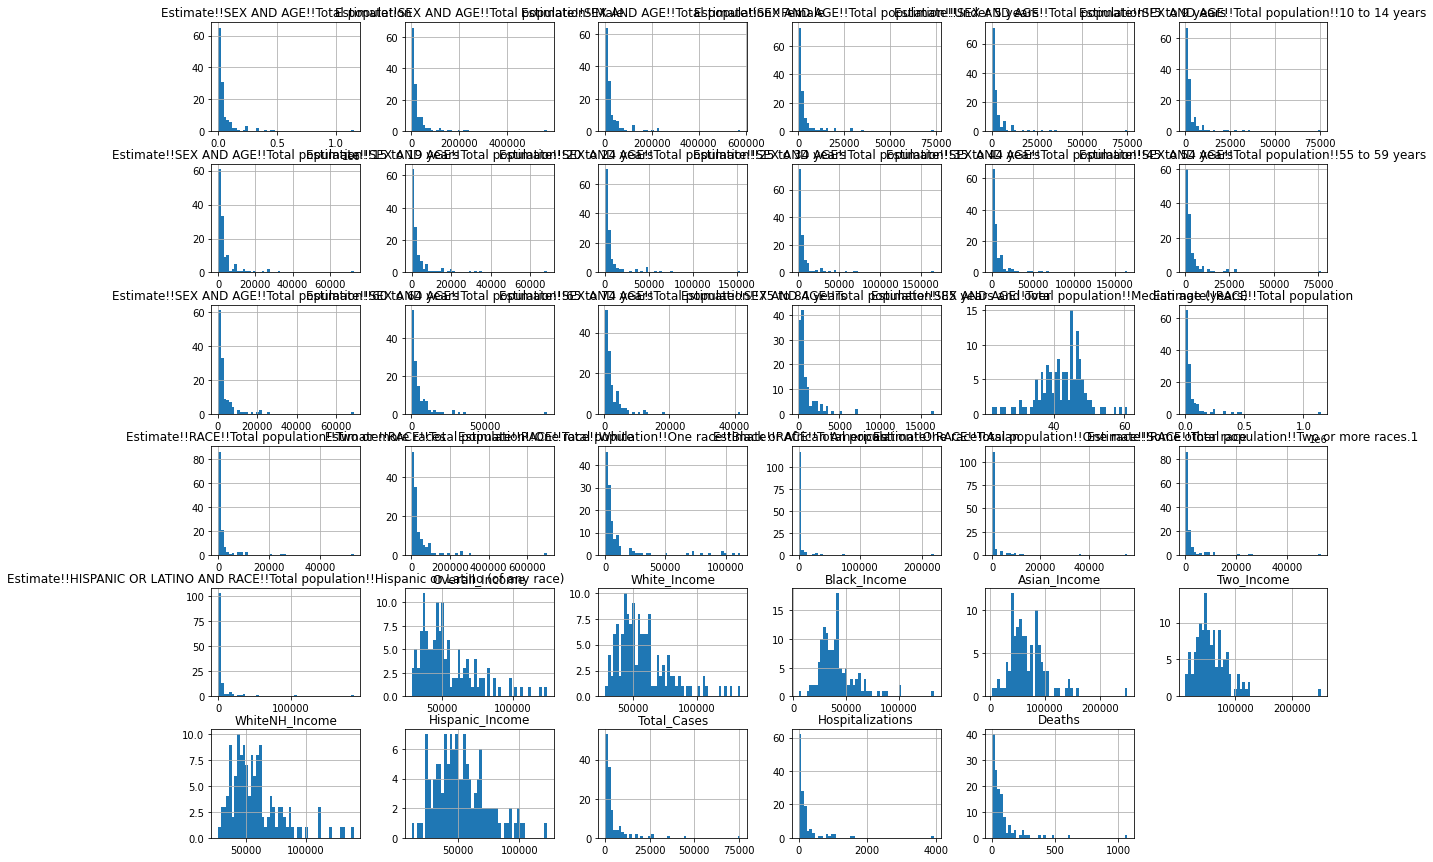

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix # optional

total_data.hist(bins=50, figsize=(20,15))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb04b6c1c90>,
      dtype=object)

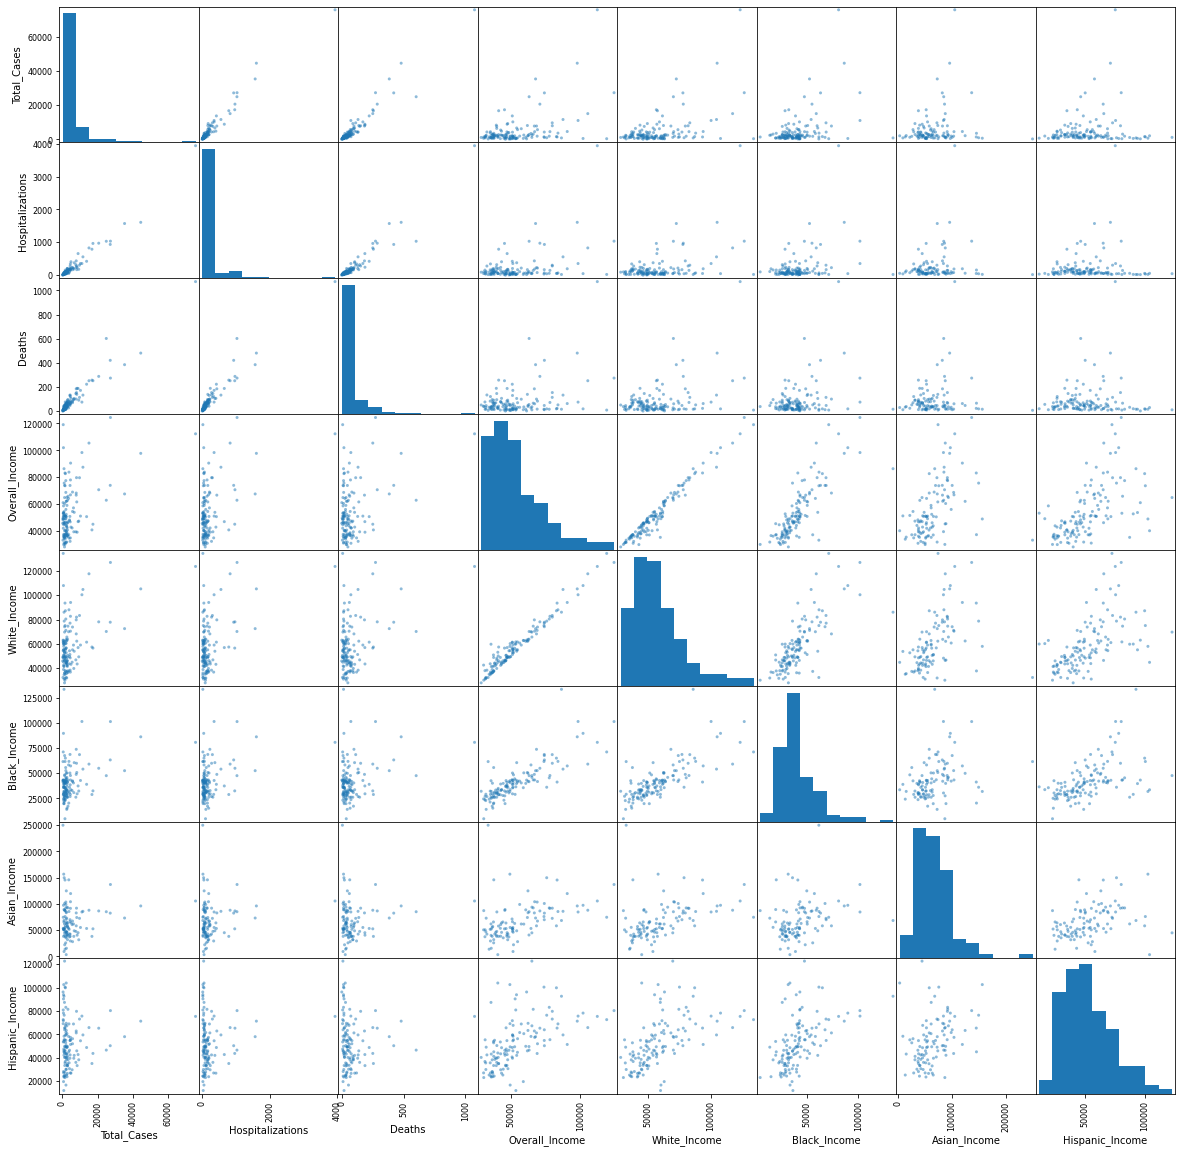

In [ ]:
attributes = ["Total_Cases", "Hospitalizations", "Deaths",
              "Overall_Income","White_Income", "Black_Income","Asian_Income", "Hispanic_Income"]
scatter_matrix(total_data[attributes], figsize=(20, 20))

In [ ]:
corr_matrix = total_data.corr()
corr_matrix.shape

(35, 35)

In [ ]:
corr_matrix["Deaths"].sort_values(ascending=False)

Deaths                                                                                       1.000000
Estimate!!SEX AND AGE!!Total population!!85 years and over                                   0.960477
Total_Cases                                                                                  0.959627
Estimate!!SEX AND AGE!!Total population!!60 to 64 years                                      0.959033
Estimate!!SEX AND AGE!!Total population!!65 to 74 years                                      0.958351
Estimate!!SEX AND AGE!!Total population!!Female                                              0.958337
Estimate!!SEX AND AGE!!Total population!!55 to 59 years                                      0.957025
Hospitalizations                                                                             0.956559
Estimate!!RACE!!Total population                                                             0.955612
Estimate!!SEX AND AGE!!Total population                                           

In [ ]:
corr_matrix["Total_Cases"].sort_values(ascending=False)

Total_Cases                                                                                  1.000000
Estimate!!SEX AND AGE!!Total population!!Under 5 years                                       0.989603
Estimate!!SEX AND AGE!!Total population!!Female                                              0.988615
Estimate!!RACE!!Total population                                                             0.988548
Estimate!!SEX AND AGE!!Total population                                                      0.988548
Estimate!!SEX AND AGE!!Total population!!Male                                                0.988096
Estimate!!SEX AND AGE!!Total population!!5 to 9 years                                        0.985581
Estimate!!SEX AND AGE!!Total population!!10 to 14 years                                      0.984414
Estimate!!SEX AND AGE!!Total population!!15 to 19 years                                      0.983088
Estimate!!SEX AND AGE!!Total population!!55 to 59 years                           

In [ ]:
corr_matrix["Hospitalizations"].sort_values(ascending=False)

Hospitalizations                                                                             1.000000
Estimate!!SEX AND AGE!!Total population!!Male                                                0.984117
Estimate!!RACE!!Total population                                                             0.983842
Estimate!!SEX AND AGE!!Total population                                                      0.983842
Estimate!!SEX AND AGE!!Total population!!Female                                              0.983201
Estimate!!SEX AND AGE!!Total population!!Under 5 years                                       0.982027
Estimate!!SEX AND AGE!!Total population!!55 to 59 years                                      0.980660
Estimate!!SEX AND AGE!!Total population!!60 to 64 years                                      0.979035
Total_Cases                                                                                  0.976940
Estimate!!SEX AND AGE!!Total population!!35 to 44 years                           

In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 35 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Estimate!!SEX AND AGE!!Total population                                                    133 non-null    float64
 1   Estimate!!SEX AND AGE!!Total population!!Male                                              133 non-null    float64
 2   Estimate!!SEX AND AGE!!Total population!!Female                                            133 non-null    float64
 3   Estimate!!SEX AND AGE!!Total population!!Under 5 years                                     133 non-null    float64
 4   Estimate!!SEX AND AGE!!Total population!!5 to 9 years                                      133 non-null    float64
 5   Estimate!!SEX AND AGE!!Total population!!10 to 14 

In [ ]:

# CASES PIPELINE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

income_ix, whiteIn_ix, blackIn_ix, asianIn_ix, twoIn_ix, hispanicIn_ix = 25, 26, 27, 28, 29, 31
population_ix, cases_ix, hospital_ix, deaths_ix = 0, 32, 33, 34
two_ix, white_ix, black_ix, asian_ix, hispanic_ix = 18, 19, 20, 21, 24
male_ix = 1

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_ratios = True): # no *args or **kargs
        self.add_ratios = add_ratios
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        cases_per_population = X[:, cases_ix] / X[:, population_ix]
        hospital_per_population = X[:, hospital_ix] / X[:, population_ix]
        deaths_per_population = X[:, deaths_ix] / X[:, population_ix]
        two_ratio = X[:, two_ix] / X[:, population_ix]
        white_ratio = X[:, white_ix] / X[:, population_ix]
        black_ratio = X[:, black_ix] / X[:, population_ix]
        asian_ratio = X[:, asian_ix] / X[:, population_ix]
        hispanic_ratio = X[:, hispanic_ix] / X[:, population_ix]

        whiteIn_ratio =  X[:, whiteIn_ix] / X[:, income_ix]
        blackIn_ratio =  X[:, blackIn_ix] / X[:, income_ix]
        asianIn_ratio =  X[:, asianIn_ix] / X[:, income_ix]
        twoIn_ratio =  X[:, twoIn_ix] / X[:, income_ix]
        hispanicIn_ratio =  X[:, hispanicIn_ix] / X[:, income_ix]
        sexage_ratios = X[:, male_ix] / X[:, population_ix]
        for i in range(2,16):
          current_ratio = X[:, i] / X[:, population_ix]
          sexage_ratios = np.c_[sexage_ratios, current_ratio]
        
        if self.add_ratios:
            return np.c_[white_ratio, black_ratio, asian_ratio, hispanic_ratio, two_ratio,
                         whiteIn_ratio, blackIn_ratio, asianIn_ratio, hispanicIn_ratio, twoIn_ratio, sexage_ratios,
                         cases_per_population, hospital_per_population, deaths_per_population]
        else:
            return X

num_attribs = list(total_data)
scale_attribs = ['Overall_Income', 'Estimate!!RACE!!Total population']

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        #('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        #("attribs_adder", CombinedAttributesAdder(), num_attribs),
        ('std_scaler', StandardScaler(), scale_attribs),
        ("num", num_pipeline, num_attribs),
        #('std_scaler', StandardScaler(), scale_attribs),
    ])

Train_prepared = full_pipeline.fit_transform(train_set)
Test_prepared = full_pipeline.fit_transform(test_set)

Train_prepared[0]

array([-0.75165885,  0.21527238,  0.62390027,  0.28976408,  0.02978968,
        0.06271352,  0.04356589,  1.10984063,  0.75596112,  1.0316893 ,
        0.85156792,  0.92958542,  0.47623175,  0.52376825,  0.06835703,
        0.06371121,  0.05515525,  0.04950166,  0.05822895,  0.15454152,
        0.12768445,  0.12961937,  0.06753066,  0.06454766,  0.09378307,
        0.03993792,  0.02740126,  0.08411855,  0.0024388 ,  0.00190469])

In [ ]:
PreptCases_train = Train_prepared[:, 27]                         #Gets the Y's for our training
PreptHospitls_train =  Train_prepared[:, 28]
PreptDeaths_train =  Train_prepared[:, 29]

X_train_set = np.delete(Train_prepared, [27,28,29], axis=1) #removes of Y's to make X_data, also removing total cases hostpitals and deaths

PreptCases_Test = Test_prepared[:, 27]                         #Gets the Y's for are training
PreptHospitls_Test =  Test_prepared[:, 28]
PreptDeaths_Test =  Test_prepared[:, 29]

X_test_set = np.delete(Test_prepared, [27,28,29], axis=1)

# Finding the best Model



In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
attributes = scale_attribs + ['white_ratio', 'black_ratio', 'asian_ratio', 'hispanic_ratio', 'two_ratio', 'whiteIn_ratio', 'blackIn_ratio', 'asianIn_ratio', 'hispanicIn_ratio', 'twoIn_ratio',
                              'male_ratio', 'female_ratio', 'Under5_ratio', '5to9_ratio', '10to14_ratio', '15to19_ratio', '20to24_ratio', '25to34_ratio', '35to44_ratio', '45to54_ratio', '55to59_ratio', 
                              '60to64_ratio', '65to74_ratio', '75to84_ratio', '85up_ratio',]
liner_reg = LinearRegression()
liner_reg.fit(X_train_set, PreptCases_train)

cases_pred_liner = liner_reg.predict(X_test_set)
liner_mse = mean_squared_error(PreptCases_Test, cases_pred_liner)
liner_rmse = np.sqrt(liner_mse)
print(liner_rmse)
evaluate(liner_reg, X_test_set, PreptCases_Test)

0.023735532587527454
Model Performance
Average Error: 0.0196 degrees.
Accuracy = 75.88%.


75.88272201008508

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_set, PreptCases_train)

cases_pred_tree = tree_reg.predict(X_test_set)
tree_mse = mean_squared_error(PreptCases_Test, cases_pred_tree)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)
evaluate(tree_reg, X_test_set, PreptCases_Test)
feature_importances = tree_reg.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

0.031066051493135727
Model Performance
Average Error: 0.0202 degrees.
Accuracy = 78.03%.


[(0.48168206167455413, 'female_ratio'),
 (0.10240955755512722, 'Estimate!!RACE!!Total population'),
 (0.06497821575853271, 'Overall_Income'),
 (0.05197266942534572, '25to34_ratio'),
 (0.04650153492568033, '10to14_ratio'),
 (0.04487859894178447, 'Under5_ratio'),
 (0.03972540704044047, 'whiteIn_ratio'),
 (0.03504597527957251, '15to19_ratio'),
 (0.02272003540067459, 'asian_ratio'),
 (0.016165817866426634, 'two_ratio'),
 (0.015369426346762664, 'blackIn_ratio'),
 (0.013686354145580493, '20to24_ratio'),
 (0.013295294563715783, '85up_ratio'),
 (0.012913169477753178, '5to9_ratio'),
 (0.011257830576599211, 'hispanicIn_ratio'),
 (0.007126797935927494, '75to84_ratio'),
 (0.004907355462010889, '45to54_ratio'),
 (0.003420440831352654, '65to74_ratio'),
 (0.003322850940441769, 'hispanic_ratio'),
 (0.0031241835629398423, '55to59_ratio'),
 (0.002064965594832364, 'asianIn_ratio'),
 (0.0015855648517096486, '35to44_ratio'),
 (0.0007636961053359457, 'twoIn_ratio'),
 (0.0006499847919064979, 'black_ratio'),


In [ ]:
#Random forests for Cases
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train_set, PreptCases_train)

cases_predictions = forest_reg.predict(X_test_set)
forest_mse = mean_squared_error(PreptCases_Test, cases_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)
evaluate(forest_reg, X_test_set, PreptCases_Test)

0.02177815782480021
Model Performance
Average Error: 0.0134 degrees.
Accuracy = 85.74%.


85.73899809774176

#Predictions for Cases

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'bootstrap': [False],
    'max_depth': [80, 90, 100, 110],
     'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
grid_search_cases = GridSearchCV(forest_reg, param_grid = param_grid, cv=5, n_jobs = -1, verbose = 2)
                           
grid_search_cases.fit(X_train_set, PreptCases_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
grid_search_cases.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [ ]:
best_grid_cases = grid_search_cases.best_estimator_
cases_predictions = best_grid_cases.predict(X_test_set)
best_grid_cases_mse = mean_squared_error(PreptCases_Test, cases_predictions)
best_grid_cases_rmse = np.sqrt(best_grid_cases_mse)
print(best_grid_cases_rmse)
grid_accuracy_cases = evaluate(best_grid_cases, X_test_set, PreptCases_Test)
feature_importances = best_grid_cases.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

0.021774280791134668
Model Performance
Average Error: 0.0138 degrees.
Accuracy = 85.13%.


[(0.12508775828278432, 'Overall_Income'),
 (0.10795051595735598, 'female_ratio'),
 (0.1047576609640821, 'male_ratio'),
 (0.054724920168965935, 'white_ratio'),
 (0.05258297839026975, 'black_ratio'),
 (0.04921272546454315, 'Estimate!!RACE!!Total population'),
 (0.0474006012711471, '25to34_ratio'),
 (0.04071363888282795, '65to74_ratio'),
 (0.03938006710711034, 'Under5_ratio'),
 (0.03618923375351059, '55to59_ratio'),
 (0.03604332160666363, 'asian_ratio'),
 (0.02682588019990396, '60to64_ratio'),
 (0.025805056600687805, 'twoIn_ratio'),
 (0.025218358568376377, 'whiteIn_ratio'),
 (0.02430661550692114, '15to19_ratio'),
 (0.023004322646905488, 'two_ratio'),
 (0.020450457052774183, 'hispanic_ratio'),
 (0.019770884077280816, 'blackIn_ratio'),
 (0.01862089426477762, '35to44_ratio'),
 (0.018281937143419635, '45to54_ratio'),
 (0.017024104796656194, '75to84_ratio'),
 (0.01599878522983089, 'hispanicIn_ratio'),
 (0.01575582588270709, '20to24_ratio'),
 (0.014165651444954405, 'asianIn_ratio'),
 (0.0137081

# Predictions for Hospitalizations

In [ ]:
#Random Forests for Hospitlzations
forest_reg_hospitl = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg_hospitl.fit(X_train_set, PreptHospitls_train)

hospitls_predictions = forest_reg_hospitl.predict(X_test_set)
forest_mse = mean_squared_error(PreptHospitls_Test, hospitls_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)
evaluate(forest_reg_hospitl, X_test_set, PreptHospitls_Test)

0.002007017110279297
Model Performance
Average Error: 0.0014 degrees.
Accuracy = 39.15%.


39.15273124741603

In [ ]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [80, 90, 100, 110],
     'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
grid_search_hospitl = GridSearchCV(forest_reg_hospitl, param_grid = param_grid, cv=5, n_jobs = -1, verbose = 2)
                           
grid_search_hospitl.fit(X_train_set, PreptHospitls_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 371 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 654 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1019 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
grid_search_hospitl.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 300}

In [ ]:
best_grid_hospitl = grid_search_hospitl.best_estimator_
hospitl_predictions = best_grid_hospitl.predict(X_test_set)
best_grid_hospitl_mse = mean_squared_error(PreptHospitls_Test, hospitl_predictions)
best_grid_hospitl_rmse = np.sqrt(best_grid_hospitl_mse)
print(best_grid_hospitl_rmse)
grid_accuracy_hospitl = evaluate(best_grid_hospitl, X_test_set, PreptHospitls_Test)
feature_importances = best_grid_hospitl.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

0.0022011236138899763
Model Performance
Average Error: 0.0013 degrees.
Accuracy = 40.90%.


[(0.18343285218186697, 'Overall_Income'),
 (0.08413958731410957, 'whiteIn_ratio'),
 (0.06603546889082065, 'white_ratio'),
 (0.06505519683432773, 'black_ratio'),
 (0.05667291040312784, 'male_ratio'),
 (0.05535447398861272, 'female_ratio'),
 (0.043342473327314494, '85up_ratio'),
 (0.040886056848146134, 'Under5_ratio'),
 (0.039002724097509565, 'asian_ratio'),
 (0.03851170888744238, 'asianIn_ratio'),
 (0.03668948731961985, 'two_ratio'),
 (0.0288758258559536, '10to14_ratio'),
 (0.024284131617199486, 'twoIn_ratio'),
 (0.023874418794359233, 'hispanic_ratio'),
 (0.022901334119448977, '35to44_ratio'),
 (0.02249889015645075, '75to84_ratio'),
 (0.021535747070981857, '20to24_ratio'),
 (0.018374059276291075, 'Estimate!!RACE!!Total population'),
 (0.017784921112729724, '25to34_ratio'),
 (0.016462302302531297, '60to64_ratio'),
 (0.016014877347963558, '15to19_ratio'),
 (0.015835727559685358, '5to9_ratio'),
 (0.014876446126810269, '45to54_ratio'),
 (0.013133434122617567, '65to74_ratio'),
 (0.0127913701

# Predictions for Deaths

In [ ]:
#Random Forest for Deaths
forest_reg_deaths = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg_deaths.fit(X_train_set, PreptDeaths_train)

deaths_predictions = forest_reg_deaths.predict(X_test_set)
forest_mse = mean_squared_error(PreptDeaths_Test, deaths_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)
evaluate(forest_reg_deaths, X_test_set, PreptDeaths_Test)

0.0013909652326914049
Model Performance
Average Error: 0.0010 degrees.
Accuracy = 35.34%.


35.34324492505202

In [ ]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [80, 90, 100, 110],
     'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
grid_search_deaths = GridSearchCV(forest_reg_deaths, param_grid = param_grid, cv=5, n_jobs = -1, verbose = 2)
                           
grid_search_deaths.fit(X_train_set, PreptDeaths_train) 

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
grid_search_deaths.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

In [ ]:
best_grid_deaths = grid_search_deaths.best_estimator_
deaths_predictions = best_grid_deaths.predict(X_test_set)
best_grid_deaths_mse = mean_squared_error(PreptDeaths_Test, deaths_predictions)
best_grid_deaths_rmse = np.sqrt(best_grid_deaths_mse)
print(best_grid_deaths_rmse)
grid_accuracy_deaths = evaluate(best_grid_deaths, X_test_set, PreptDeaths_Test)
feature_importances = best_grid_deaths.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

0.0014181458119879237
Model Performance
Average Error: 0.0009 degrees.
Accuracy = 40.98%.


[(0.1785141398764859, 'Overall_Income'),
 (0.11433397513310802, 'female_ratio'),
 (0.1027744354983341, 'male_ratio'),
 (0.06320875155803642, 'white_ratio'),
 (0.06035659288763053, 'black_ratio'),
 (0.05470607736861172, 'whiteIn_ratio'),
 (0.053048502980214414, '85up_ratio'),
 (0.042945457837112004, 'twoIn_ratio'),
 (0.034007275841806385, '35to44_ratio'),
 (0.03165244901489492, '10to14_ratio'),
 (0.025216565374432762, 'asian_ratio'),
 (0.02489851295592892, 'two_ratio'),
 (0.024585677045175437, '75to84_ratio'),
 (0.02450863537758398, '60to64_ratio'),
 (0.024101017726186086, 'Estimate!!RACE!!Total population'),
 (0.020225598059680615, 'hispanic_ratio'),
 (0.015749070566759272, '65to74_ratio'),
 (0.014887172872068167, '45to54_ratio'),
 (0.014885397067426339, 'Under5_ratio'),
 (0.01332547256252829, 'asianIn_ratio'),
 (0.012105329277782094, '55to59_ratio'),
 (0.011018522167495316, '25to34_ratio'),
 (0.010315213982268862, '5to9_ratio'),
 (0.008673870123412492, 'blackIn_ratio'),
 (0.0070604111